In [118]:
# !pip install tensorflow yfinance scikeras

# Objetivo
 - Prever o preço de fechamento da ação da Apple (AAPL) para o próximo dia, utilizando LSTM.


In [119]:
# Importação de bibliotecas
import random
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow import random as tf_random

from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ks_2samp  # Para teste de drift

In [120]:
random.seed(42)
np.random.seed(42)
tf_random.set_seed(42)

In [121]:
# ======================================
# 1. Coleta e Pré-processamento dos Dados
# ======================================

# Coleta de dados históricos
# Ação da Apple (AAPL)
symbol = 'AAPL'
start_date = '2018-01-01'
end_date = '2024-12-01'

# Coleta de dados com yfinance
print("Coletando dados...")
data = yf.download(symbol, start=start_date, end=end_date)

# Seleção do preço de fechamento ajustado ()
data = data[['Adj Close']].rename(columns={'Adj Close': 'Close'})

# Normalização dos dados
# Para que todos os valores fiquem entre 0 e 1 (Melhor eficiência do Modelo LSTM)
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

# Exibição das primeiras linhas dos dados coletados
print(data.head())

[*********************100%***********************]  1 of 1 completed

Coletando dados...
Price                         Close
Ticker                         AAPL
Date                               
2018-01-02 00:00:00+00:00  0.032313
2018-01-03 00:00:00+00:00  0.032279
2018-01-04 00:00:00+00:00  0.033204
2018-01-05 00:00:00+00:00  0.035483
2018-01-08 00:00:00+00:00  0.034731


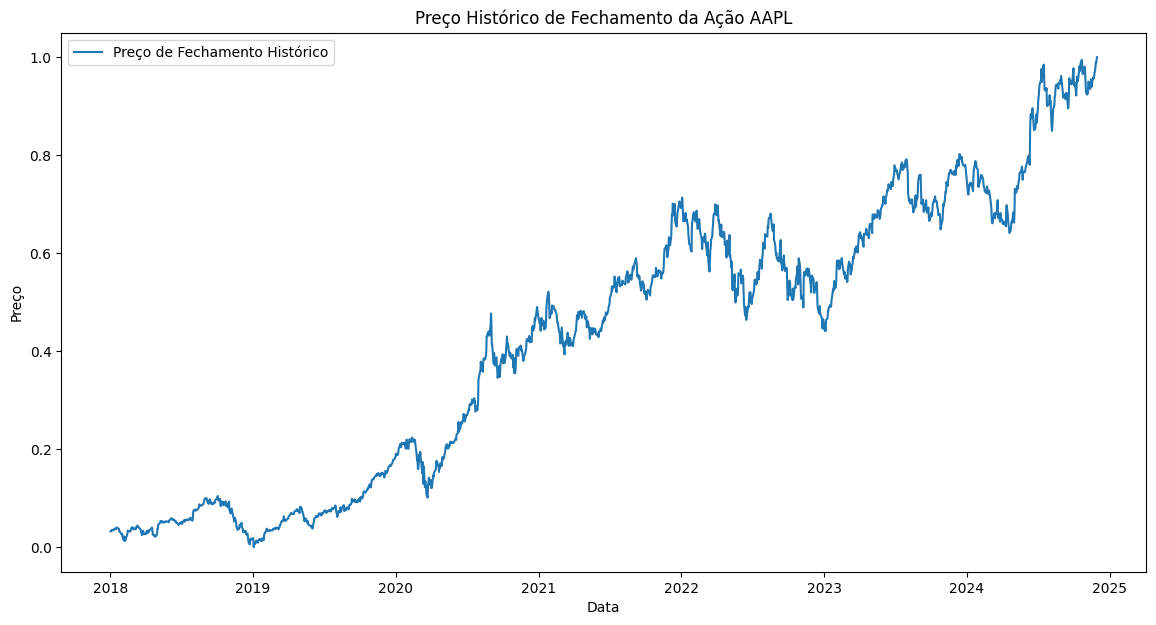

In [122]:
# Gráfico de Preço Histórico
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Preço de Fechamento Histórico')
plt.title('Preço Histórico de Fechamento da Ação AAPL')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

In [123]:
# ======================================
# 2. Preparação dos Dados para o Modelo
# ======================================

# Criando sequências para o modelo LSTM
# Para que o modelo LSTM consiga capturar padrões temporais, criamos sequências
# de 60 dias para prever o próximo dia.
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0]) # 60 dias anteriores
        y.append(data[i, 0]) # Próximo valor
    return np.array(X), np.array(y)

# Convertendo os dados para o formato numpy
data_values = data.values
X, y = create_sequences(data_values)

# Dividindo os dados em treino e teste (80% treino, 20% teste)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Redimensionando para 3D (requisito da LSTM)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [124]:
# ==========================================================================
# 3. Desenvolvimento do Modelo LSTM - Seleção dos melhores parâmetros
# ==========================================================================
# Construção do Modelo LSTM com Regularização L2
# O LSTM é usado para capturar padrões temporais nos dados sequenciais.

print("Construindo o modelo LSTM...")

# Função para construir o modelo
def build_model(neurons=50, optimizer='adam'):
    model = Sequential([
        LSTM(neurons, input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrapping do modelo
model = KerasRegressor(build_fn=build_model, verbose=0)

# Definição do grid de parâmetros
param_grid = {
    'model__neurons': [50],
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop']
}

# GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Exibir os melhores parâmetros
print(f"Melhores parâmetros: {grid_result.best_params_}")
print(f"Melhor pontuação: {grid_result.best_score_}")

Construindo o modelo LSTM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Melhores parâmetros: {'batch_size': 16, 'epochs': 20, 'model__neurons': 50, 'optimizer': 'adam'}
Melhor pontuação: 0.8121166742978995


In [125]:
# ======================================
# 4. Previsão e Avaliação do Modelo
# ======================================

# Treinando o modelo final com os melhores parâmetros
best_params = grid_result.best_params_
final_model = build_model(neurons=best_params['model__neurons'], optimizer=best_params['optimizer'])
final_model.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=2)

# Avaliação do modelo
y_pred = final_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Cálculo das métricas
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print(f"MAE (Erro Absoluto Médio): {mae}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse}")


Epoch 1/20
84/84 - 3s - 33ms/step - loss: 0.0314
Epoch 2/20
84/84 - 2s - 25ms/step - loss: 0.0097
Epoch 3/20
84/84 - 1s - 14ms/step - loss: 0.0063
Epoch 4/20
84/84 - 1s - 16ms/step - loss: 0.0049
Epoch 5/20
84/84 - 1s - 10ms/step - loss: 0.0042
Epoch 6/20
84/84 - 1s - 10ms/step - loss: 0.0034
Epoch 7/20
84/84 - 1s - 10ms/step - loss: 0.0035
Epoch 8/20
84/84 - 1s - 15ms/step - loss: 0.0031
Epoch 9/20
84/84 - 1s - 10ms/step - loss: 0.0028
Epoch 10/20
84/84 - 1s - 16ms/step - loss: 0.0027
Epoch 11/20
84/84 - 1s - 15ms/step - loss: 0.0024
Epoch 12/20
84/84 - 1s - 17ms/step - loss: 0.0024
Epoch 13/20
84/84 - 2s - 24ms/step - loss: 0.0023
Epoch 14/20
84/84 - 1s - 15ms/step - loss: 0.0023
Epoch 15/20
84/84 - 1s - 15ms/step - loss: 0.0019
Epoch 16/20
84/84 - 1s - 10ms/step - loss: 0.0021
Epoch 17/20
84/84 - 1s - 15ms/step - loss: 0.0020
Epoch 18/20
84/84 - 1s - 10ms/step - loss: 0.0020
Epoch 19/20
84/84 - 1s - 10ms/step - loss: 0.0018
Epoch 20/20
84/84 - 1s - 15ms/step - loss: 0.0018
11/11 ━━━

In [126]:
# Teste de Drift
# (Verificar se houve mudança na distribuição dos dados de entrada ao longo do tempo)
# teste Kolmogorov-Smirnov de duas amostras.
# Se o p-value for maior que 0.05, não há drift

def test_drift(X_train, X_new):
    _, p_value = ks_2samp(X_train.flatten(), X_new.flatten())
    return p_value > 0.05

recent_data = X_test[-100:]
drift_detected = test_drift(X_train, recent_data)
if drift_detected:
    print("Drift detectado! Recomenda-se re-treinar o modelo.")
else:
    print("Sem drift detectado.")

Sem drift detectado.


In [128]:
# ======================================
# 5. Salvamento e Exportação do Modelo
# ======================================

# Salvando o modelo treinado
print("Salvando o modelo...")
final_model.save("lstm_stock_model.h5") #formato .h5
final_model.save("lstm_stock_model.keras") #formato Keras


Salvando o modelo...


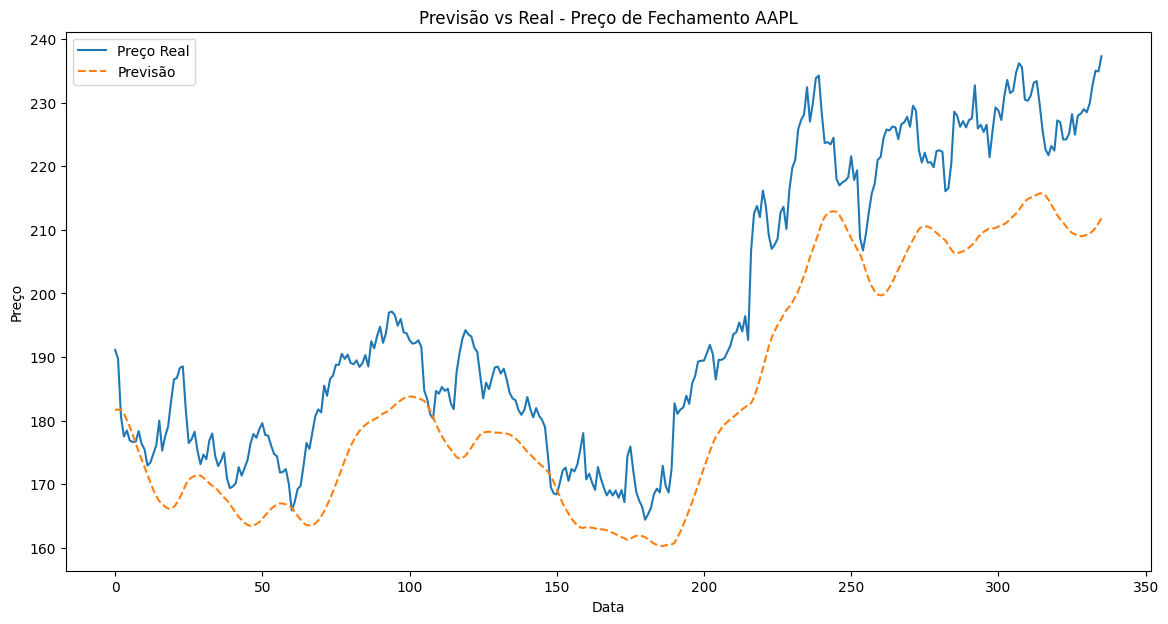

In [129]:
# Gráfico da Previsão vs Real
plt.figure(figsize=(14,7))
plt.plot(y_test_actual, label='Preço Real')
plt.plot(y_pred, label='Previsão', linestyle='dashed')
plt.title('Previsão vs Real - Preço de Fechamento AAPL')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()


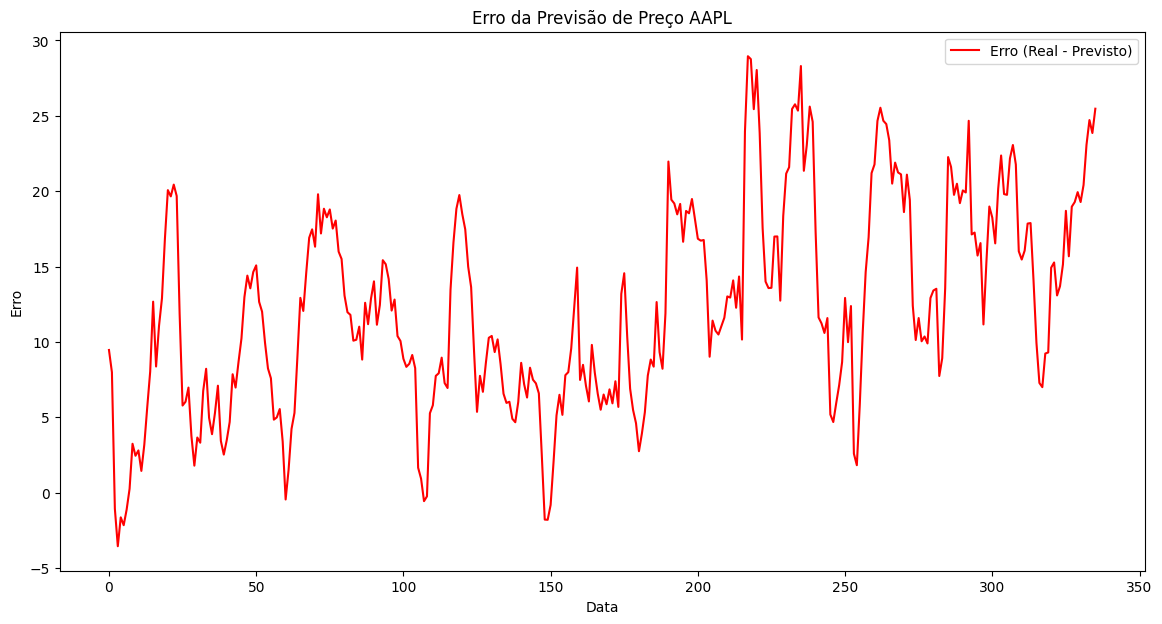

In [130]:
# Gráfico de Erro
error = y_test_actual - y_pred
plt.figure(figsize=(14,7))
plt.plot(error, label='Erro (Real - Previsto)', color='red')
plt.title('Erro da Previsão de Preço AAPL')
plt.xlabel('Data')
plt.ylabel('Erro')
plt.legend()
plt.show()



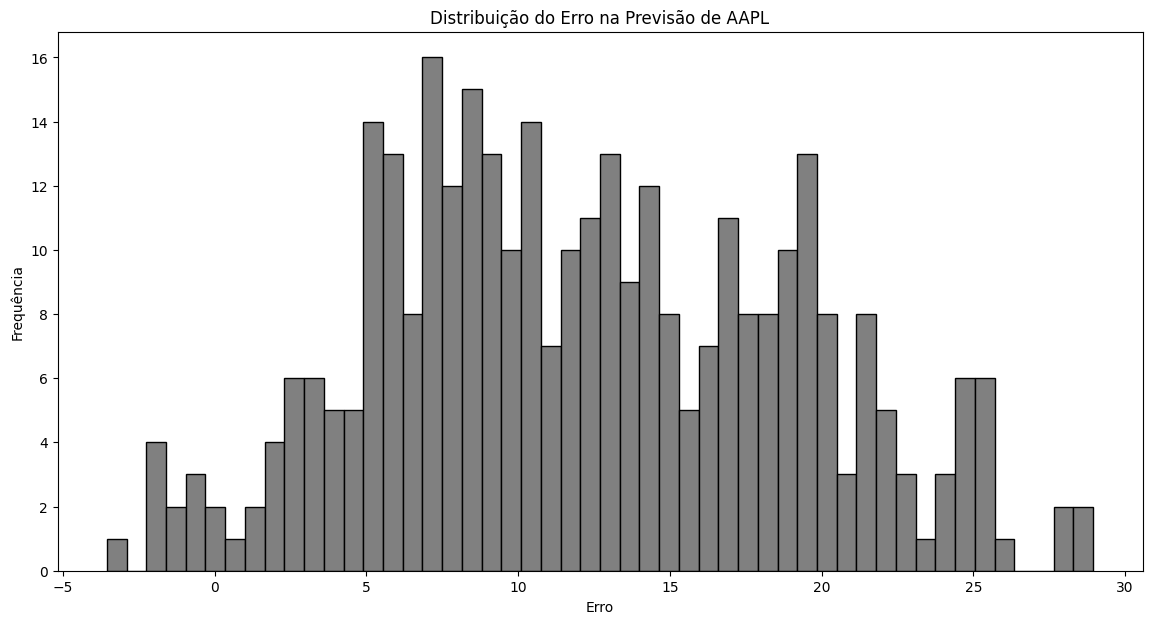

In [131]:
# Gráfico de Distribuição do Erro
plt.figure(figsize=(14,7))
plt.hist(error, bins=50, color='gray', edgecolor='black')
plt.title('Distribuição do Erro na Previsão de AAPL')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.show()